# Biostat M280 Homework 2
# Sarah Ji
**Due May 11 @ 11:59PM**

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).
In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Later in the course we will learn how to derive a majorization-minimization (MM) algorithm with iterative updates
$$
	v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
	w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. Efficiency (both speed and memory) will be the most important criterion when grading this problem.


1. Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.
```julia
function nnmf(
    X::Matrix, 
    r::Int;
    maxiter::Int=1000, 
    tol::eltype(X)=1e-4,
    V::Matrix{eltype(X)}=rand(size(X, 1), r),
    W::Matrix{eltype(X)}=rand(r, size(X, 2))
    )
    # implementation
    # Output
    return V, W
end
```

0. Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  
Read in the [`nnmf-2429-by-361-face.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm()`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readdlm-Tuple{Any,Char,Type,Char}) function, and display a couple sample images, e.g., using [ImageView.jl](https://github.com/JuliaImages/ImageView.jl) package.

0. Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt)) and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

0. Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

0. (Optional) Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in part 2.

## Q1.1 Solution:

In [3]:
#using for loop
function nnmf(
        X::Matrix{T},
        r::Integer;
        maxiter::Integer=1000, 
        tol::Number=1e-4,
        V::Matrix{T}=rand(T, size(X, 1), r),
        W::Matrix{T}=rand(T, r, size(X, 2))
        ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    A_mul_B!(A, V, W)
    A .= X .- A
    l_last = abs2(vecnorm(A, 2))
    
    for i in 1:maxiter
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U', 'N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U', 'T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
        if (abs(l_new - l_last) / (abs(l_last) + 1)) <= tol
            break
        end
        l_last = l_new
    end
    
    return V, W
end

nnmf (generic function with 1 method)

In [3]:
# compared nnmf to nnmf2 which uses while loop instead of for loop
# the performance is not as good so I will use nnmf as the final function implementation.
function nnmf2(
        X::Matrix{T},
        r::Integer;
        maxiter::Integer=1000, 
        tol::Number=1e-4,
        V::Matrix{T}=rand(T, size(X, 1), r),
        W::Matrix{T}=rand(T, r, size(X, 2))
        ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    l_new = abs2(vecnorm(X - V * W, 2))
    l_last = 0.0
    count = 0
    
    while (abs(l_new - l_last) / (abs(l_last) + 1)) > tol && count < maxiter
        l_last = l_new
        count += 1
        
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U','N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U','T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
    end
    return V, W
end

nnmf2 (generic function with 1 method)

I have implemented an algorithm with arguments: `X` (data, each row is a vectorized image), rank  `r`, convergence tolerance `tol`, and optional starting points `V` and `W`.

## Q1.2 Solution:

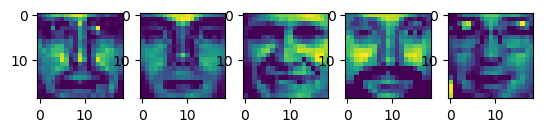

PyObject <matplotlib.image.AxesImage object at 0x148d49b50>

In [9]:
#Pkg.add("ImageView")
using ImageView
using PyPlot

X = readdlm("nnmf-2429-by-361-face.txt")
img1 = X[1,:]
img1 = reshape(img1, 19, 19)
img2 = X[13,:]
img2 = reshape(img2, 19, 19)
img3 = X[35, :]
img3 = reshape(img3, 19, 19)
img4 = X[125, :]
img4 = reshape(img4, 19, 19)
img5 = X[130, :]
img5 = reshape(img5, 19, 19)

subplot(1, 5, 1)
PyPlot.imshow(img1)
subplot(1, 5, 2)
PyPlot.imshow(img2)
subplot(1, 5, 3)
PyPlot.imshow(img3)
subplot(1, 5, 4)
PyPlot.imshow(img4)
subplot(1, 5, 5)
PyPlot.imshow(img5)

I have read in the `nnmf-2429-by-361-face.txt file` using the readdlm() function and displayed a five sample images in my notebook using the ImageView.jl and PyPlot.jl packages. Notice the different features of each persons face, picked up by the image! Each of the rows of the $\mathbf{X}$ are the pixels for a different individuals face in the sample. 

## Q1.3 Solution:

In [11]:
V0 = readdlm("V0.txt");
W0 = readdlm("W0.txt");
# with rank 10 its blurrier than with rank 50 because we are capturing less information from the original X

@time nnmf(X, 10, V = V0[:, 1:10], W = W0[1:10, :])
@time nnmf(X, 20, V = V0[:, 1:20], W = W0[1:20, :])
@time nnmf(X, 30, V = V0[:, 1:30], W = W0[1:30, :])
@time nnmf(X, 40, V = V0[:, 1:40], W = W0[1:40, :])
@time nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

  2.716634 seconds (25 allocations: 7.331 MiB)
  3.569488 seconds (33 allocations: 7.972 MiB, 0.17% gc time)
  5.875026 seconds (25 allocations: 8.614 MiB)
  8.732550 seconds (25 allocations: 9.258 MiB)
 13.128490 seconds (26 allocations: 9.903 MiB, 0.04% gc time)


([4.06515e-8 0.0239183 … 0.00502753 0.0308952; 2.06692e-5 0.0167692 … 0.00168436 0.0335739; … ; 0.0136536 0.0204076 … 8.933e-5 0.0451226; 0.0182157 0.00994188 … 5.39374e-6 0.000142989], [1.98839e-64 1.24767e-53 … 2.73192e-14 8.87992e-65; 5.00853e-27 2.38036e-26 … 2.00588e-32 4.48034e-61; … ; 3.60097e-15 2.70773e-15 … 3.86231e-22 2.41101e-44; 0.000249871 6.68716e-20 … 2.36259e-7 1.30468e-11])

Above we use `@time` on our function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$, with the first $r$ columns of `V0.txt` and the first $r$ rows of `W0.txt` and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$


In addition, we check the benchmark to get a more robust estimate of the runtime and memory allocation.

In [24]:
using BenchmarkTools
@benchmark nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

BenchmarkTools.Trial: 
  memory estimate:  9.90 MiB
  allocs estimate:  22
  --------------
  minimum time:     10.744 s (0.00% GC)
  median time:      10.744 s (0.00% GC)
  mean time:        10.744 s (0.00% GC)
  maximum time:     10.744 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

## Q1.4 Solution:

For r = 50, we do not obtain the same objective value and (V, W) are not the same from that of Q1.3.

In [13]:
V_50, W_50 = nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])
V_r, W_r = nnmf(X, 50) #with random starting points

([0.0313329 0.00703249 … 0.0207635 3.10162e-18; 0.0205671 0.00641766 … 0.0238345 0.00213217; … ; 8.1961e-8 0.00815619 … 0.0229242 0.00478911; 0.0173447 0.00494082 … 0.0237537 0.0113963], [3.65108e-37 1.03949e-22 … 1.3592e-8 3.52385e-69; 4.74768e-40 3.51854e-17 … 1.40341e-12 1.17764e-55; … ; 9.74744e-41 1.25524e-33 … 4.29157e-18 1.80434e-40; 2.56267e-22 1.2632e-18 … 20.8062 17.1294])

In [14]:
@show L_50 = abs2(vecnorm((X .- (V_50 * W_50)), 2))
@show L_random = abs2(vecnorm((X .- (V_r * W_r)), 2))

L_50 = abs2(vecnorm(X .- V_50 * W_50, 2)) = 4430.201581697289
L_random = abs2(vecnorm(X .- V_r * W_r, 2)) = 4388.971390067497


4388.971390067497

Notice how the squared Frobenius norms differ in `L_50` vs. `L_random`. Since the function is not a convex problem, indicating one global minima, when we optimize it from different starting points we may get different local minimums.

## Q1.5 Solution:

In [32]:
V_1, W_1 = nnmf(X, 50, V = ones(2429, 50), W = ones(50, 361))

@show V_50 == V_1
@show W_50 == W_1

VW_1 = V_1 * W_1 # like our new X for initial values 1
VW_50 = V_50 * W_50 # X = VW with first 50 columns and 50 rows 

@show L_one = abs2(vecnorm((X .- (V_1 * W_1)), 2))
@show L_50 = abs2(vecnorm((X .- (V_50 * W_50)), 2));

V_50 == V_1 = false
W_50 == W_1 = false
L_one = abs2(vecnorm(X .- V_1 * W_1, 2)) = 25297.01651108185
L_50 = abs2(vecnorm(X .- V_50 * W_50, 2)) = 4430.201581697289


For the same  r = 50, initializing the algorithm from matrices of all ones, we do not obtain the same objective value or values of V and W. 

We check using the function `nnmfOneDemo`, which is essentially the same as the function nnmf but it only outputs how many iterations it takes for the function to converge. I created a separate function so the runtime and memory allocation of nnmf would not be altered. It shows that the function breaks out of the iteration loop when `i = 3`, indicating that it takes 2 updates of V and W for the stopping criteria to be met: 

$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

In [18]:
#using for loop
function nnmfOneDemo(
        X::Matrix{T},
        r::Integer;
        maxiter::Integer=1000, 
        tol::Number=1e-4,
        V::Matrix{T}=rand(T, size(X, 1), r),
        W::Matrix{T}=rand(T, r, size(X, 2))
        ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    A_mul_B!(A, V, W)
    A .= X .- A
    l_last = abs2(vecnorm(A, 2))

    for i in 1:maxiter
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U', 'N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U', 'T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
        if (abs(l_new - l_last) / (abs(l_last) + 1)) <= tol
            println(i)
            break
        end
        l_last = l_new
    end
    
    return V, W
end

nnmfOneDemo (generic function with 1 method)

In [45]:
nnmfOneDemo(X, 50, V =  V = ones(2429, 50), W = ones(50, 361))

3


([0.00547494 0.00547494 … 0.00547494 0.00547494; 0.00544131 0.00544131 … 0.00544131 0.00544131; … ; 0.00570319 0.00570319 … 0.00570319 0.00570319; 0.00560599 0.00560599 … 0.00560599 0.00560599], [0.369943 0.460643 … 0.5581 0.425542; 0.369943 0.460643 … 0.5581 0.425542; … ; 0.369943 0.460643 … 0.5581 0.425542; 0.369943 0.460643 … 0.5581 0.425542])

Below, we compare the images of individuals in the rows of VW_1 and VW_50. 
<br>
We notice that VW_1 is the mean of X, and each row has some variation of the average American face in our sample. On the other hand, we see that VW_50 has different individuals in each row.

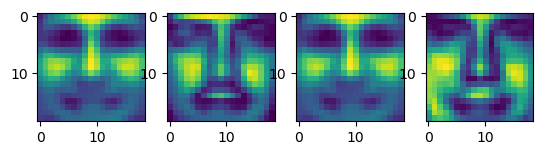

PyObject <matplotlib.image.AxesImage object at 0x137070290>

In [16]:
subplot(1, 4, 1)
PyPlot.imshow(reshape(VW_1[1, :], 19, 19))
subplot(1, 4, 2)
PyPlot.imshow(reshape(VW_50[1, :], 19, 19))
subplot(1, 4, 3)
PyPlot.imshow(reshape(VW_1[60, :], 19, 19))
subplot(1, 4, 4)
PyPlot.imshow(reshape(VW_50[60, :], 19, 19))

Below, we prove that with initial values of 1's for V and W, the function `nnmf` takes 2 updates of $\mathbf{V}$ and $\mathbf{W}$ for $\mathbf{VW}$ to converge to the mean of the original matrix $\mathbf{X}$. 

Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$

When we give the initial values of ones, it converges in 2 steps, then the third iteration doesn't change anything thus breaks the loop.

Note that when we plot the rows of the VW_1, we only get one face. That is, each row of VW_1 contains data which maps to the average American face thats in our original dataset X. 

Below, we show mathematically, that after two iterations $\mathbf{X - V_2W_2}$ is the mean centered version of the original X matix:

$\mathbf{PROOF:}$
>Initializing the values of V and W, we have:
$$\mathbf{V} = \mathbf{1_m}\mathbf{1_r}^{T}$$ and $$\mathbf{W} = \mathbf{1_r}\mathbf{1_n}^{T}$$
>and the following updates for V and W:
$$\mathbf{V} = \mathbf{V} .* \mathbf{X}\mathbf{W}^{T} ./ (\mathbf{VW{W}^T})$$
$$\mathbf{W} = \mathbf{W} .* \mathbf{V}^{T}\mathbf{X} ./ (\mathbf{{V}^{T}VW})$$
<br>

1V) First iteration of V:
>We start with the numerator of V, $\mathbf{X}\mathbf{W}^{T}$:
$$\mathbf{X}\mathbf{W}^{T} = \mathbf{X}\mathbf{1_n}\mathbf{1_r}^{T} = \mathbf{1_m}\mathbf{\sum_{j=1}^n {x_{ij}}}\mathbf{1_r}^{T}, i \in [1, m]$$ where i indicates the ith row of the original X matrix, which has m rows in total.
<br>
>Now making note of the fact that each image (row in original X) is scaled to have mean and standard deviation 0.25, we note that $\sum_{i=1}^n {x_{ij}} = 0.25(n),$ thus we have:
$$\mathbf{1_m}0.25(n)\mathbf{1_r}^{T} = 0.25(n)\mathbf{1_m}\mathbf{1_r}^{T}, i \in [1, m]$$
<br>
>Now working on the denominator of V, $\mathbf{VW{W}^T}$:
$$\mathbf{VW{W}^T} = \mathbf{1_m}\mathbf{1_r}^{T}(\mathbf{1_r}\mathbf{1_n}^{T})(\mathbf{1_n}\mathbf{1_r}^{T})$$
$$ = \mathbf{1_m}(rn)\mathbf{1_r}^{T}$$
$$ = nr\mathbf{1_m}\mathbf{1_r}^{T}$$
<br>
>Now we can update our initial value of V (matrix of ones) as follows:
$$\mathbf{V_1} = \mathbf{1_m}\mathbf{1_r}^{T} .* 0.25(n)\mathbf{1_m}\mathbf{1_r}^{T} ./ (nr\mathbf{1_m}\mathbf{1_r}^{T})$$
$$= \frac{0.25}{r}\mathbf{1_m}\mathbf{1_r}^{T}$$
<br>

1W) First iteration of W:

>We start with the numerator of W, $\mathbf{V}^{T}\mathbf{X}$, using $\mathbf{V_1}$ from above:
$$\mathbf{V}^{T}\mathbf{X} = (\frac{0.25}{r}\mathbf{1_m}\mathbf{1_r}^{T})\mathbf{X} = \mathbf{1_r}m(0.25)\mathbf{1_n}^{T} = m(0.25)\mathbf{1_r}\mathbf{1_n}^{T}$$
<br>
>Now working on the denominator of V, $\mathbf{{V}^{T}VW}$:
$$\mathbf{{V}^{T}VW} = ({\frac{0.25}{r}})^{2}(\mathbf{1_r}\mathbf{1_m}^{T})\mathbf{1_m}\mathbf{1_r}^{T}(\mathbf{1_r}\mathbf{1_n}^{T})$$
> Since $\mathbf{1_m}^{T}\mathbf{1_m} = m $ and $\mathbf{1_r}^{T}\mathbf{1_r} = r,$ we have:
$$\mathbf{{V}^{T}VW} = ({\frac{0.25}{r}})^{2}(\mathbf{1_r}(m)(r)\mathbf{1_n}^{T})$$
<br>
$$ = ({\frac{0.25}{r}})^{2}mr(\mathbf{1_r}\mathbf{1_n}^{T}) $$
<br>
$$ = ({\frac{0.25^{2}}{r}})m(\mathbf{1_r}\mathbf{1_n}^{T}) $$
<br>
>Now we can update our initial value of V (matrix of ones) as follows:
$$\mathbf{W_1} = \mathbf{1_r}\mathbf{1_n}^{T} .* m(0.25)\mathbf{1_r}\mathbf{1_n}^{T} ./ ({\frac{0.25^{2}}{r}})m(\mathbf{1_r}\mathbf{1_n}^{T})$$
$$= \frac{mr}{0.25}\mathbf{1_r}\mathbf{1_n}^{T}$$
<br>

2V) Similarly, we do the Second iteration of V and W using the values of V_1 and W_1 as the new starting points.

>We start with the numerator of V_2, $\mathbf{X}\mathbf{W}^{T}$:
$$\mathbf{X}\mathbf{W}^{T} = \frac{mr}{0.25}\mathbf{X}\mathbf{1_r}\mathbf{1_n}^{T}$$ <br>
$$ = mrn\mathbf{1_m}\mathbf{1_r}^{T}$$
<br>
>Now working on the denominator of V_2, $\mathbf{VW{W}^T}$:
$$\mathbf{VW{W}^T} = \frac{0.25}{r}\mathbf{1_m}\mathbf{1_r}^{T}(\frac{mr}{0.25})^{2}\mathbf{1_r}\mathbf{1_n}^{T}\mathbf{1_n}\mathbf{1_r}^{T}$$<br>
$$ = \mathbf{1_m}(rn)\mathbf{1_r}^{T}$$
$$ = \frac{m^{2}r^{2}n}{0.25}\mathbf{1_m}\mathbf{1_r}^{T}$$
<br>
>Now we can update our value of V_1 with V_2 as follows:
$$\mathbf{V_2} = \frac{0.25}{r}\mathbf{1_m}\mathbf{1_r}^{T} .* mrn\mathbf{1_m}\mathbf{1_r}^{T} ./ (\frac{m^{2}r^{2}n}{0.25}\mathbf{1_m}\mathbf{1_r}^{T})$$
$$= \frac{0.25^{2}}{mr^{2}}\mathbf{1_m}\mathbf{1_r}^{T}$$
<br>


2W) Second iteration of W:

>We start with the numerator of W_2, $\mathbf{V}^{T}\mathbf{X}$, using $\mathbf{V_2}$ from above:
$$\mathbf{V}^{T}\mathbf{X} = (\frac{0.25^{2}}{mr^{2}}\mathbf{1_r}\mathbf{1_m}^{T})\mathbf{X} = (\frac{0.25^{2}}{mr^{2}}\mathbf{1_r}(0.25m)\mathbf{1_n}^{T}) = \frac{0.25^{3}}{r^{2}}\mathbf{1_r}\mathbf{1_n}^{T}$$
<br>
>Now working on the denominator of W_2, $\mathbf{{V_1}^{T}V_1W_1}$:
$$\mathbf{{V_1}^{T}V_1W_1} = ({\frac{0.25^{4}}{m^{2}r4}})(\mathbf{1_r}\mathbf{1_m}^{T})(\mathbf{1_m}\mathbf{1_r}^{T})(\frac{mr}{0.25})\mathbf{1_r}\mathbf{1_n}^{T}$$<br>
$$ = (\frac{mr}{0.25})\mathbf{1_r}\mathbf{1_n}^{T}$$
<br>
>Now we can update our value of W_2 as follows:
$$\mathbf{W_2} = \frac{mr}{0.25}\mathbf{1_r}\mathbf{1_n}^{T} .* \frac{0.25^{3}}{r^{2}}\mathbf{1_r}\mathbf{1_n}^{T} ./ (\frac{mr}{0.25})\mathbf{1_r}\mathbf{1_n}^{T})$$<br>
$$= \frac{mr}{0.25}\mathbf{1_r}\mathbf{1_n}^{T}$$
<br>

**Calculating X - VW after 2 iterations:**
<br>
>First we will calculate the product $\mathbf{V_2} * \mathbf{W_2}:$
$$\mathbf{V_2W_2} = \frac{0.25^{2}}{mr^{2}}\mathbf{1_m}\mathbf{1_r}^{T}\frac{mr}{0.25}\mathbf{1_r}\mathbf{1_n}^{T}$$<br>
$$ = \frac{0.25}{r}\mathbf{1_m}\mathbf{1_r}^{T}\mathbf{1_r}\mathbf{1_n}^{T}$$<br>
$$ = \frac{0.25}{r}(r)\mathbf{1_m}\mathbf{1_n}^{T}$$ <br>
$$ = 0.25\mathbf{1_m}\mathbf{1_n}^{T}$$
<br>
>Then, for $\mathbf{X}$ is a mxn matrix we will calculate the quanitity $\mathbf{X - V_2W_2}:$<br>
$$\mathbf{X} .- 0.25\mathbf{1_m}\mathbf{1_n}^{T}$$<br>
>Thus we note that this is the mean centered version of the original X matrix after two iterations of updating the values of V and W from initial matrices of all ones.

## Q1.6 Solution:

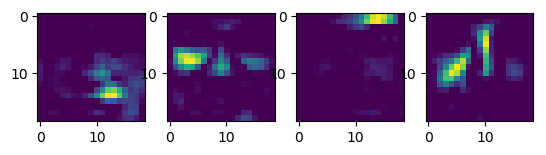

In [22]:
V, W = nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

W_img1 = W[1, :]
W_img1 = reshape(W_img1, 19, 19)

W_img2 = W[2, :]
W_img2 = reshape(W_img2, 19, 19)

W_img5 = W[9, :]
W_img5 = reshape(W_img5, 19, 19)

W_img10 = W[10, :]
W_img10 = reshape(W_img10, 19, 19)

#VW = V*W
subplot(1, 4, 1)
PyPlot.imshow(W_img1)
subplot(1, 4, 2)
PyPlot.imshow(W_img2)
subplot(1, 4, 3)
PyPlot.imshow(W_img5)
subplot(1, 4, 4)
PyPlot.imshow(W_img10);

Above, we plot the basis images (rows of  W) at rank  r = 50. 

Note that from the first row, we see a glimpse of the image of the upper lip of an individual's face.
From the second row, we see what appears to be the right cheekbone of an individual's face. 
From the ninth row, we see what appears to be the forehead of an individual's face. 
From the tenth row, we see what appears to be the nose bridge and right cheekbone of an individual's face. 

## Q2. Linear Mixed Models

Consider a linear mixed effects model
$$
	y_i = \mathbf{x}_i^T \beta + \mathbf{z}_i^T \gamma + \epsilon_i, \quad i=1,\ldots,n,
$$
where $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. 

0. Show that 
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

0. Write a function, with interface 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. Make your code efficient in the $n \gg q$ case. 

0. Compare your result (both accuracy and timing) to the [Distributions.jl](http://distributionsjl.readthedocs.io/en/latest/multivariate.html#multivariate-normal-distribution) package using following data.  
    ```julia
    using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
    @benchmark logpdf(mvn, y)
    ```

## Q2.1 Solution:

Below I will show that:
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

$${f(\mathbf{y}) = \frac1{sqrt(2\pi))^p|\mathbf{\Sigma}|^{1/2}}} * e^{-(\mathbf{y}-\mathbf{\mu})^{T}\mathbf{\Sigma}^{-1}(\mathbf{y}-\mu)/2}$$ 
<br>
>Take the log of both sides to get the log pdf:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}log|\mathbf{\Sigma}| - \frac{[(\mathbf{y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{y}-\mathbf{\mu})]}{2}$$
<br>

>Now, we use the **Woodbury formula**:
$$(\mathbf{A} + \mathbf{U} \mathbf{V}^T)^{-1} = \mathbf{A}^{-1} - \mathbf{A}^{-1} \mathbf{U} (\mathbf{I}_m + \mathbf{V}^T \mathbf{A}^{-1} \mathbf{U})^{-1} \mathbf{V}^T \mathbf{A}^{-1},
$$
where $\mathbf{A} \in \mathbb{R}^{n \times n}$ is nonsingular, $\mathbf{U}, \mathbf{V} \in \mathbb{R}^{n \times m}$, and $\mathbf{I}_m$ is the $m \times m$ identity matrix.

>Let $\mathbf{A} = \sigma_0^{2}\mathbf{I}$ and $\mathbf{U} = \mathbf{V} = \sigma_1\mathbf{Z}$
<br>
Using the Woodbury Formula and properties of determinants of block matrices, we can plug in $\mathbf{|\Sigma|}$ and $\mathbf{\Sigma^{-1}}$ as follows into the logpdf:
<br>

$$\mathbf{\Sigma^{-1}} = ({\sigma_0^{2}}\mathbf{I} + \sigma_1^{2}\mathbf{Z{Z}^{T}})^{-1}\mathbf{Z^{T}} = \sigma_0^{-2}\mathbf{I} - \sigma_0^{-4}\sigma_1^{2}*\mathbf{Z}* (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})\mathbf{Z^{T}}$$
<br>
>Now making use of the property of the determinants of block matrices below:
$$\text{det}(\mathbf{A} + \mathbf{U} \mathbf{V}^T) = \text{det}(\mathbf{A}) \text{det}(\mathbf{I}_m + \mathbf{V}^T \mathbf{A}^{-1} \mathbf{U}).
$$
>We get:
$$\mathbf{|\Sigma|} = det({\sigma_0^{2}}\mathbf{I} + \sigma_1^{2}\mathbf{Z{Z}^{T}}) = det({\sigma_0^{2}}\mathbf{I}) * det(\mathbf{I} + \sigma_0^{-2}\sigma_1^{2}\mathbf{Z^{T}Z}) = {\sigma_0^{2n}} * (\mathbf{I} + \sigma_0^{-2}\sigma_1^{2}\mathbf{Z^{T}Z})$$

<br>
$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}log|\mathbf{\Sigma}| - \frac{[(\mathbf{y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{y}-\mathbf{\mu})]}{2}$$
<br>

>where we note that: log|$\mathbf{\Sigma}|$ = 2 * n * log(σ0) + logdet($\mathbf{I}$ + $\sigma_0^{-2}$*$\sigma_1^{2}\mathbf{Z^{T}Z}$))
<br>

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + $\sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{[(\mathbf{y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{y}-\mathbf{\mu})]}{2}$$
<br>

>Since we are given that $\mathbf{\mu}$ = 0, we can rewrite the log-pdf as:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + $\sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{[(\mathbf{y})^T\mathbf{\Sigma}^{-1}(\mathbf{y})]}{2}$$
<br>

>Substituting in $\mathbf{\Sigma^{-1}}$ we have:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{[(\mathbf{y})^T(\sigma_0^{-2}\mathbf{I} - \sigma_0^{-4}*\sigma_1^{2}*\mathbf{Z}(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z}))(\mathbf{y})]}{2}$$
<br>

>Now distributing out the $y$ and $y^T$ we get:

$$log(f(\mathbf{y})) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}*(2 * n * log(σ0) + logdet(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})) - \frac{(\mathbf{y})^T(\sigma_0^{-2})\mathbf{y}}{2} + (\frac{\sigma_1}{\sigma_0^{2}}\mathbf{{y}^{T}Z})(\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})(\mathbf{{Z}^{T}}\mathbf{y}\frac{\sigma_1}{\sigma_0^{2}})$$

>Thus, we write the function below, utilizing symmetric and positive definite structure of $\mathbf{\Sigma} = (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})$ through Cholesky Decomposition. We then can use this decomposition to speed up efficiency and reduce our benchmarking run time, when computing the determinant or solving the linear system of equations in the last term.

>Now we we will show that the variance evaluates the variance of the log-density of a multivariate normal with mean 0 and and covariance matrix $\mathbf{\Sigma} = (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})$<br>
<br>
>First we start by showing that the mean of $\mathbf{y}$ is $\mathbf{0}$:
$$\mathbf{y} = \mathbf{X} \mathbf{\beta} + \mathbf{Z}^T \mathbf{\gamma} + \mathbf{\epsilon}$$
<br>
$$E[\mathbf{y}] = E[\mathbf{X} \beta + \mathbf{Z}^T \mathbf{\gamma} + \mathbf{\epsilon}]$$
<br>
$$E[\mathbf{y}] = E[\mathbf{X} \beta] + E[\mathbf{Z}^T \mathbf{\gamma}] + E[\mathbf{\epsilon}]$$
<br>
$$E[\mathbf{y}] = E[\mathbf{X}]\mathbf{\beta} + \mathbf{Z}^TE[\mathbf{\gamma}] + E[\mathbf{\epsilon}]$$
<br> 
>Recall that we are given that $\epsilon_i$ are independent normal errors $N(\mathbf{0},\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\mathbf{\gamma} \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. Then plugging in $E[\mathbf{\gamma}] = \mathbf{0}$ and $E[\mathbf{\epsilon}] = \mathbf{0}$, we get:
<br>
$$E[\mathbf{y}] = E[\mathbf{X}]\mathbf{\beta} + \mathbf{Z}^T[\mathbf{0}] + [\mathbf{0}]$$
>And then we make note of the fact that X is a matrix of fixed effects, so we get:
$$E[\mathbf{y}] = \mathbf{X}\mathbf{\beta}$$
<br>

>Now we we will show that the covariance of y evaluates to $\mathbf{\Sigma} = (\mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z})$
<br>
$$Var(\mathbf{y}) = Var(\mathbf{X} \beta + \mathbf{Z}^T \mathbf{\gamma} + \mathbf{\epsilon})$$
<br>
$$Var(\mathbf{y}) = Var(\mathbf{X} \beta) + Var(\mathbf{Z}^T \mathbf{\gamma}) + Var(\mathbf{\epsilon})$$
<br>
>Now, making note of the fact that $Var(\mathbf{X}\mathbf{\beta}) = 0$, since $\mathbf{\beta}$ and $\mathbf{X}$ are fixed constants, we get:
$$Var(\mathbf{y}) = 0 + \mathbf{Z}^TVar(\mathbf{\gamma})\mathbf{Z} + Var(\mathbf{\epsilon})$$
<br>
>Now plugging in $Var(\mathbf{\gamma}) = \sigma_1^2 \mathbf{I}_q$ and $Var(\mathbf{\epsilon}) = \sigma_0^2$ we get:
<br>
$$Var(\mathbf{y}) = \mathbf{Z}^T(\sigma_1^2 \mathbf{I}_q)\mathbf{Z} + \sigma_0^2(\mathbf{I})$$
<br>
$$Var(\mathbf{y}) = \mathbf{I} + \sigma_0^{-2}*\sigma_1^{2}\mathbf{Z^{T}Z}$$

## Q2.2

Below I have written a function, made efficient for the $n \gg q$ case. 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. 

In [33]:
# better efficiency
function logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    n = length(y)
    Σchol = cholfact!(σ1^2/σ0^2 * (Z' * Z) + I)
    logdetΣchol = 2 * n * log(σ0) + logdet(Σchol)
    - (n//2) * log(2π) - (1//2) * logdetΣchol - (1//2) * (sum(abs2, y)/σ0^2 -
        sum(abs2, Σchol[:L] \ ((Z' * y) * (σ1/σ0^2))))
end

logpdf_mvn (generic function with 1 method)

## Q2.3 Solution:

Below I compare the results by both accuracy and timing, to the `logpdf()` function in the Distributions.jl package using the given data.

First, I check if we get the same value out from our function and the built in function, and we do! Using the given data as inputs, both functions return a value of -1571.573673465 with some minor floating point rounding margin between the two (which is negligable). 

In [34]:
using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
@show logpdf_mvn(y, Z, σ0, σ1)
@show logpdf(mvn, y)

logpdf_mvn(y, Z, σ0, σ1) = -1571.5736734653365
logpdf(mvn, y) = -1571.5736734654135


-1571.5736734654135

Below we use the BenchmarkingTools.jl package to benchmark the two functions, and compare efficiency.

In [27]:
# benchmark
@benchmark logpdf_mvn(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  4.17 KiB
  allocs estimate:  16
  --------------
  minimum time:     37.784 μs (0.00% GC)
  median time:      56.675 μs (0.00% GC)
  mean time:        61.678 μs (0.81% GC)
  maximum time:     3.099 ms (92.81% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [28]:
@benchmark logpdf(mvn, y)

BenchmarkTools.Trial: 
  memory estimate:  15.78 KiB
  allocs estimate:  3
  --------------
  minimum time:     3.922 ms (0.00% GC)
  median time:      6.345 ms (0.00% GC)
  mean time:        6.081 ms (0.00% GC)
  maximum time:     10.068 ms (0.00% GC)
  --------------
  samples:          819
  evals/sample:     1

### Memory:

Notice how my function implementation of the logpdf take on average 4.17 KiB of memory while the built in logpdf function implementation takes on average 15.78 KiB of memory.

This indicates that our function allocates about 15.78/4.17 = 3.78 fold less memory than the built in function. 

### Timing:

Notice how my function implementation of the logpdf takes a median of 56.675 μs while the built in logpdf function implementation takes a median of 6.345 ms to run.

This indicates that our function is about 6.345/.056675 = 111.95 fold faster than the built in function! 

Small, fast and wicked cool~